<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [1]:
import matplotlib.pyplot as plt

% matplotlib inline

In [72]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])

print(boston['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [73]:
# Exploratory data analysis.
# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column

In [74]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(13)
memory usage: 51.5 KB


In [75]:
X.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.593761   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.596783   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.647423   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.105710    8.707259  168.537116    2.164946   91.294864   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.025000    2.100175    4.000000  279.000000   17.400000  375.377500   
50%     77.500000    3.207450    5.000000  330.000000   19.050000  391.440000   
75%     94.075000    5.188425   24.000000  666.000000   20.200000  396.225000   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            LSTAT  
count  506.000000  
mean    12.653063  
std      7.141062  
min      1.730000  
25%      6.950000  
50%     11.360000  
75%     16.955000  
max     37.970000

In [76]:
# There is NO null values in attributes or target column of 506 observations

In [77]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 1 columns):
MEDV    506 non-null float64
dtypes: float64(1)
memory usage: 4.0 KB


In [78]:
y.describe()

MEDV
count  506.000000
mean    22.532806
std      9.197104
min      5.000000
25%     17.025000
50%     21.200000
75%     25.000000
max     50.000000

In [79]:
# All 13 attributes and 1 target are all float

In [80]:
X.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33

In [81]:
y.describe()

MEDV
count  506.000000
mean    22.532806
std      9.197104
min      5.000000
25%     17.025000
50%     21.200000
75%     25.000000
max     50.000000

In [82]:
X.nunique()

CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
dtype: int64

In [83]:
y.nunique()

MEDV    229
dtype: int64

In [84]:
data = pd.concat([X, y], axis=1)

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

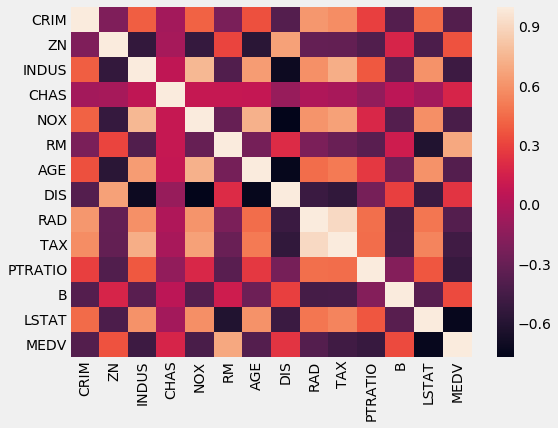

In [85]:
# Before choosing the predictors, plot a heatmap so as to see which features we can choose
import seaborn as sns
sns.heatmap(data.corr())

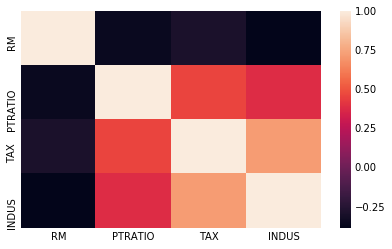

In [132]:
# look at the last row, pick 4 attributes columns that are most correlated to the the target values, the darkest or least dark
# note that
features_cols = ['RM','PTRATIO','TAX','INDUS']
Xs=X[features_cols]

sns.heatmap(Xs.corr())
# the heat map shows that the four chosen attributes are not strongly correlate to each other

In [133]:
dataset = pd.concat([Xs, y], axis=1)
dataset.head()

RM  PTRATIO    TAX  INDUS  MEDV
0  6.575     15.3  296.0   2.31  24.0
1  6.421     17.8  242.0   7.07  21.6
2  7.185     17.8  242.0   7.07  34.7
3  6.998     18.7  222.0   2.18  33.4
4  7.147     18.7  222.0   2.18  36.2

In [134]:
from sklearn.linear_model import LinearRegression

#instantiate
linreg = LinearRegression()
# fit the linear regression Y against X1
linreg.fit(Xs, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

[-0.89941799]
[[ 7.12195917 -0.90495814 -0.00854671 -0.10201484]]


In [135]:
#score the lr model, which returns the coefficient of determination R^2 of the prediction, best is 1
linreg.score(X1,y)

-12.955559246320435

In [136]:
# the R^ score is rather low, meaning the actual y values is not very fitted in the linear regression model

In [137]:
#plot the errors of the predictions using the lr model
y_pred= linreg.predict(Xs)
# adding y_pred col to dataset for plotting later
dataset['MEDV_pred']=y_pred
dataset.head(3)

RM  PTRATIO    TAX  INDUS  MEDV  MEDV_pred
0  6.575     15.3  296.0   2.31  24.0  29.316125
1  6.421     17.8  242.0   7.07  21.6  25.932879
2  7.185     17.8  242.0   7.07  34.7  31.374056

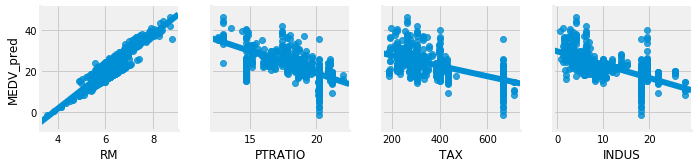

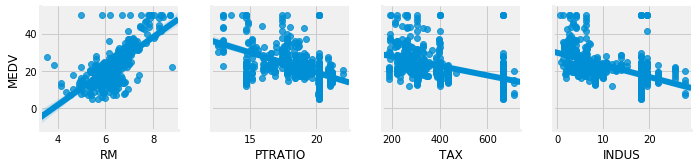

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#use pairplots to show the correlation betwee the predicted values of MEDV against the four chosen attributes
sns.pairplot(dataset, x_vars=Xs.columns, y_vars='MEDV_pred', kind='reg');
sns.pairplot(dataset, x_vars=Xs.columns, y_vars='MEDV', kind='reg');

In [21]:
#RMSE of the model
from sklearn import metrics
print(np.sqrt(metrics.mean_squared_error(y, y_pred)))

5.134226319457686


### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [140]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Define a function that accepts Xs and Y values, a parameter as a testing data set size (30% or 10%) and returns testing RMSE.
def train_test_rmse(Xs,Y, testsize):
    
    X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=testsize, random_state=123)
    
    #get lr model on training dataset
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    # get predicted y on x values from test set
    y_pred = linreg.predict(X_test)
    # get the RMSE from predicted y versus actual y in the testing set
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

# get the RMSE of 70/30 split
train_test_rmse(X1, y, 0.3)

5.8607878546920285

In [141]:
# get the RMSE of 90/10 split
train_test_rmse(X1, y, 0.1)

7.159621141961487

In [142]:
#RMSE decreases with the increasing size of the testing data set.
# this can be explained by that fact that in a larger testing data set, errors caused by the outliers, the freak events have more
# chance of being evened out by no-outliers values, hence the RMSR is lowered

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [143]:
from sklearn import model_selection

In [162]:
# define a function that takes Xsm y the number of fold in k-cross validation and return RMSE and R^2

def get_RMSE_R2_crossval(Xs, y, k):
    
    kf = model_selection.KFold(n_splits=k, shuffle=True)

    rmse_values = []
    scores = []
    n = 0

    #print("~~~~ CROSS VALIDATION each fold ~~~~")
    for train_index, test_index in kf.split(Xs, y):
        lr = LinearRegression().fit(Xs.iloc[train_index], y.iloc[train_index])

        rmse_values.append(np.sqrt(metrics.mean_squared_error(y.iloc[test_index], lr.predict(Xs.iloc[test_index]))))
        scores.append(lr.score(Xs, y))

        n += 1

        print('Model {}'.format(n))
        print('RMSE: {}'.format(rmse_values[n-1]))
        print('R2: {}\n'.format(scores[n-1]))


    print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
    print('Mean of RMSE for all folds: {}'.format(np.mean(rmse_values)))
    print('Mean of R2 for all folds: {}'.format(np.mean(scores)))
    
get_RMSE_R2_crossval(Xs, y, 5)

Model 1
RMSE: 5.967145074266897
R2: 0.5962080575262052

Model 2
RMSE: 7.404836686252704
R2: 0.5931966967913658

Model 3
RMSE: 6.329859098869287
R2: 0.5955204207453664

Model 4
RMSE: 4.834694383430386
R2: 0.5936496878199216

Model 5
RMSE: 4.931806798312932
R2: 0.5943349957890853

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of RMSE for all folds: 5.893668408226441
Mean of R2 for all folds: 0.5945819717343889


In [163]:
get_RMSE_R2_crossval(Xs, y, 6)

Model 1
RMSE: 7.320441145147052
R2: 0.5964277820111279

Model 2
RMSE: 6.151430237335144
R2: 0.5955589328256357

Model 3
RMSE: 4.231329046987973
R2: 0.5955035817918684

Model 4
RMSE: 4.404407317916059
R2: 0.5960075363044555

Model 5
RMSE: 4.6933092481160985
R2: 0.5960574723693056

Model 6
RMSE: 7.558660611342148
R2: 0.5964101174711836

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of RMSE for all folds: 5.726596267807412
Mean of R2 for all folds: 0.5959942371289294


In [164]:
get_RMSE_R2_crossval(Xs, y, 7)

Model 1
RMSE: 7.9356101060948685
R2: 0.595675403141799

Model 2
RMSE: 6.067314102090855
R2: 0.5962022541149565

Model 3
RMSE: 4.167755726496892
R2: 0.5958823635209729

Model 4
RMSE: 7.625282064191729
R2: 0.5949825395667734

Model 5
RMSE: 4.385797169728477
R2: 0.5961627008975007

Model 6
RMSE: 5.539801449936826
R2: 0.59592763040176

Model 7
RMSE: 4.344763302449372
R2: 0.5964028544970383

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of RMSE for all folds: 5.723760560141288
Mean of R2 for all folds: 0.5958908208772572


In [165]:
get_RMSE_R2_crossval(Xs, y, 8)

Model 1
RMSE: 7.01301564553929
R2: 0.5959522886933851

Model 2
RMSE: 6.091927463703914
R2: 0.596090601626712

Model 3
RMSE: 5.728091199487241
R2: 0.596186062056185

Model 4
RMSE: 4.723097261512337
R2: 0.5964310217913718

Model 5
RMSE: 5.756907298286783
R2: 0.5944713754229314

Model 6
RMSE: 7.083348064618845
R2: 0.5966875676590987

Model 7
RMSE: 5.285508224893426
R2: 0.5965939425287377

Model 8
RMSE: 5.064843200877673
R2: 0.5962228446982831

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of RMSE for all folds: 5.8433422948649385
Mean of R2 for all folds: 0.596079463059588


In [166]:
get_RMSE_R2_crossval(Xs, y, 9)

Model 1
RMSE: 7.13309265504943
R2: 0.5953105874991202

Model 2
RMSE: 5.640793637401438
R2: 0.5962391495128864

Model 3
RMSE: 4.928903986366318
R2: 0.5965832230860634

Model 4
RMSE: 4.617889633559339
R2: 0.5959954539359124

Model 5
RMSE: 6.247600985235584
R2: 0.5959596445480801

Model 6
RMSE: 5.323473034431231
R2: 0.595927144928081

Model 7
RMSE: 6.011020156749272
R2: 0.5955929811465142

Model 8
RMSE: 7.897374795404634
R2: 0.5961970103337397

Model 9
RMSE: 4.614705567301866
R2: 0.5959329738595902

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of RMSE for all folds: 5.823872716833235
Mean of R2 for all folds: 0.5959709076499986


In [168]:
get_RMSE_R2_crossval(Xs, y, 10)

Model 1
RMSE: 7.108869650018026
R2: 0.59618799473593

Model 2
RMSE: 7.350271890733201
R2: 0.592669919539142

Model 3
RMSE: 6.446644551406982
R2: 0.5960764548272459

Model 4
RMSE: 4.326593272469257
R2: 0.5958570481804089

Model 5
RMSE: 4.432737972405228
R2: 0.5965117165753624

Model 6
RMSE: 5.00453390618652
R2: 0.5960585698478722

Model 7
RMSE: 7.3028329396496945
R2: 0.5961337392875536

Model 8
RMSE: 7.6532304560822775
R2: 0.5959688682025401

Model 9
RMSE: 3.523886949337658
R2: 0.5963831293871193

Model 10
RMSE: 4.472208811089635
R2: 0.5966293575452137

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of RMSE for all folds: 5.762181039937849
Mean of R2 for all folds: 0.5958476798128388


In [179]:
def get_RMSE_R2_crossval2(Xs, y, k):
    
    kf = model_selection.KFold(n_splits=k, shuffle=True)

    rmse_values = []
    scores = []
    n = 0

    #print("~~~~ CROSS VALIDATION each fold ~~~~")
    for train_index, test_index in kf.split(Xs, y):
        lr = LinearRegression().fit(Xs.iloc[train_index], y.iloc[train_index])

        rmse_values.append(np.sqrt(metrics.mean_squared_error(y.iloc[test_index], lr.predict(Xs.iloc[test_index]))))
        scores.append(lr.score(Xs, y))

        n += 1

        #print('Model {}'.format(n))
        #print('RMSE: {}'.format(rmse_values[n-1]))
        #print('R2: {}\n'.format(scores[n-1]))


    #print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
    #print('Mean of RMSE for all folds: {}'.format(np.mean(rmse_values)))
    #print('Mean of R2 for all folds: {}'.format(np.mean(scores)))
    return np.mean(rmse_values), np.mean(scores)
    
get_RMSE_R2_crossval2(Xs, y, 5)

(5.842048558368959, 0.5955087014740215)

In [186]:
v =get_RMSE_R2_crossval2(Xs, y, 5)[0]
v

5.8778771643451115

In [195]:
avg_rmse = []
avg_score = []
folds = []

for i in range(5,11):
    folds.append(i)
    rmse, scr = get_RMSE_R2_crossval2(Xs,y,i)

    avg_rmse.append(rmse)
    avg_score.append(scr)

print(folds)
print(avg_rmse)
print(avg_score)

[5, 6, 7, 8, 9, 10]
[5.753703222326503, 5.816297032401835, 5.785369697472829, 5.810438161822613, 5.869299938570013, 5.82649341033243]
[0.5950004492248203, 0.5959004559968406, 0.5958228060985947, 0.5959241358245142, 0.5959447559331079, 0.5960067493627152]


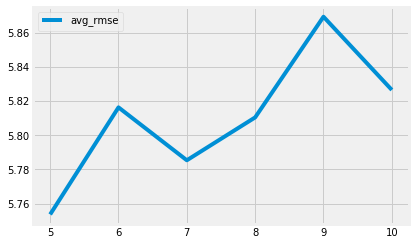

In [212]:
from matplotlib import pyplot as plt
#plotting the changes of RMSE with the number of folds
pd.DataFrame(avg_rmse,index=folds, columns=['avg_rmse']).plot()

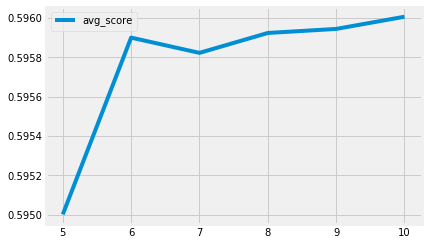

In [214]:
pd.DataFrame(avg_score,index=folds, columns=['avg_score']).plot()

In [35]:
# model evaluation metrics like RMSE and R2 do not differ much when we do 5-fold and any number of folds till 10

In [36]:
#note that the lower the K, the larger the testing size, outliers impact can ben evened out by non-outliers values more often,
#hence the RMSE is lower
#in short, the higher the k, the higher the RMSE

# KNN Practice

In [37]:
# Read the iris data into a DataFrame
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)
iris.head()

sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

In [215]:
# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

In [216]:
# Create a custom colormap
from matplotlib.colors import ListedColormap
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

In [222]:
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'
#create a dictionary to map each iris species to a  number
species_map_dict = {'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}

iris['species_num']= iris['species'].map(lambda x: species_map_dict[x])
iris.head()

sepal_length  sepal_width  petal_length  petal_width      species  \
0           5.1          3.5           1.4          0.2  Iris-setosa   
1           4.9          3.0           1.4          0.2  Iris-setosa   
2           4.7          3.2           1.3          0.2  Iris-setosa   
3           4.6          3.1           1.5          0.2  Iris-setosa   
4           5.0          3.6           1.4          0.2  Iris-setosa   

   species_num  
0            0  
1            0  
2            0  
3            0  
4            0

In [223]:
species_color_map_dict = {'Iris-setosa':'red', 'Iris-versicolor':'green', 'Iris-virginica':'blue'}
iris['species_color_code'] = iris['species'].map(lambda x: species_color_map_dict[x])
iris.head()

sepal_length  sepal_width  petal_length  petal_width      species  \
0           5.1          3.5           1.4          0.2  Iris-setosa   
1           4.9          3.0           1.4          0.2  Iris-setosa   
2           4.7          3.2           1.3          0.2  Iris-setosa   
3           4.6          3.1           1.5          0.2  Iris-setosa   
4           5.0          3.6           1.4          0.2  Iris-setosa   

   species_num species_color_code  
0            0                red  
1            0                red  
2            0                red  
3            0                red  
4            0                red

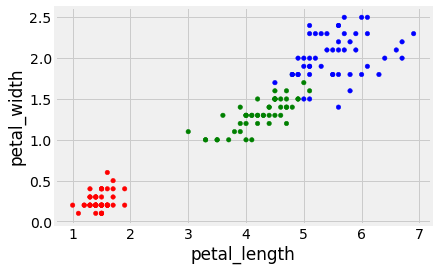

In [231]:
# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
iris.plot(kind='scatter',x= 'petal_length', y='petal_width', color=iris['species_color_code'])


In [ ]:
# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES

## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [41]:
features_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X=iris[features_cols]
X.head(2)

sepal_length  sepal_width  petal_length  petal_width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2

### Create your target vector "y"
This will be the species type.

In [42]:
y = iris['species']
y.head(2)

#label encode
from sklearn.preprocessing import LabelEncoder
#import numpy as np

le = LabelEncoder()
iris['species_num'] = le.fit_transform(iris['species'])
iris.head(3)

sepal_length  sepal_width  petal_length  petal_width      species  \
0           5.1          3.5           1.4          0.2  Iris-setosa   
1           4.9          3.0           1.4          0.2  Iris-setosa   
2           4.7          3.2           1.3          0.2  Iris-setosa   

   species_num  
0            0  
1            0  
2            0

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [43]:
from sklearn.model_selection import train_test_split

X = iris.drop(['species','species_num'], axis = 1)
y = iris['species_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

knn = KNeighborsClassifier(n_neighbors=1) #instantiate a model with one neighbor
knn.fit(X_train, y_train) #fit

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [45]:
y_pred_class = knn.predict(X_test)

print((metrics.accuracy_score(y_test, y_pred_class)))

1.0


### Create a Model With Five Neighbors. Did it Improve?

In [46]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class))) # k=50 is not much better either

0.8666666666666667


### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [47]:
for k in range(1,51):     
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_class = knn.predict(X_test)
    
    print ('k =',k)
    print('Accuracy score of KNN model =',(metrics.accuracy_score(y_test, y_pred_class)))

k = 1
Accuracy score of KNN model = 1.0
k = 2
Accuracy score of KNN model = 0.9666666666666667
k = 3
Accuracy score of KNN model = 0.9666666666666667
k = 4
Accuracy score of KNN model = 1.0
k = 5
Accuracy score of KNN model = 0.9666666666666667
k = 6
Accuracy score of KNN model = 1.0
k = 7
Accuracy score of KNN model = 1.0
k = 8
Accuracy score of KNN model = 1.0
k = 9
Accuracy score of KNN model = 1.0
k = 10
Accuracy score of KNN model = 1.0
k = 11
Accuracy score of KNN model = 1.0
k = 12
Accuracy score of KNN model = 1.0
k = 13
Accuracy score of KNN model = 1.0
k = 14
Accuracy score of KNN model = 1.0
k = 15
Accuracy score of KNN model = 1.0
k = 16
Accuracy score of KNN model = 1.0
k = 17
Accuracy score of KNN model = 1.0
k = 18
Accuracy score of KNN model = 1.0
k = 19
Accuracy score of KNN model = 1.0
k = 20
Accuracy score of KNN model = 1.0
k = 21
Accuracy score of KNN model = 1.0
k = 22
Accuracy score of KNN model = 1.0
k = 23
Accuracy score of KNN model = 1.0
k = 24
Accuracy score

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [48]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

In [49]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     1220.
Date:                Sun, 30 Sep 2018   Prob (F-statistic):          1.59e-321
Time:                        12:12:03   Log-Likelihood:                -1567.7
No. Observations:                 506   AIC:                             3151.
Df Residuals:                     498   BIC:                             3185.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             4.9744      0.224     22.197      0.000       4.534       5.415
LSTAT         -0.5615      0.048    -11.817      0.000      -0.655      -0.468
RAD            0.2109      0.070      3.025      0.003       0.074       0.348
TAX           -0.0174      0.004     -4.267      0.000      -0.025      -0.009
NOX            4.3456      3.385      1.284      0.200      -2.305      10.997
INDUS          0.0925      0.067      1.385      0.167      -0.039       0.224
CRIM          -0.0866      0.037     -2.362      0.019      -0.159      -0.015
ZN             0.0288      0.013      2.215      0.027       0.003       0.054
==============================================================================
Omnibus:                      192.072   Durbin-Watson:                   0.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              831.634
Skew:                           1.665   Prob(JB):                    2.59e-181
Kurtosis:                       8.325   Cond. No.                     6.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

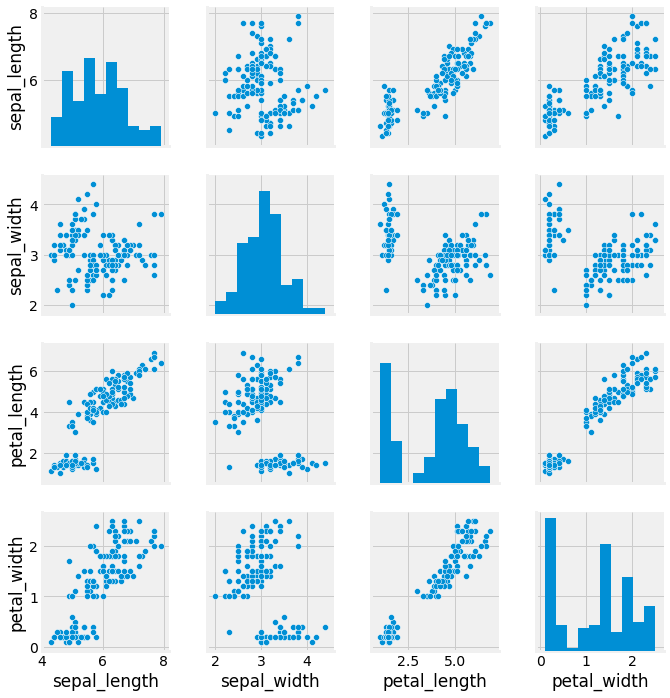

In [50]:
# Check out variable relations
import seaborn as sns

sns.pairplot(X);

In [51]:
# Check out Pearson scores


## Demo: Patsy

In [52]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [53]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


C:\Users\harriet.ly\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [54]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))

R^2 Score: 0.21218268739892143
